In [3]:
from bs4 import BeautifulSoup
import requests
import re
from selenium import webdriver

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report,precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import shap

from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB
import xgboost


In [16]:
base_dat = pd.read_pickle("./FINAL_data.pkl")
# somewhere along the collection we got a few duplicate documents. We should remove them.
base_dat = base_dat.drop_duplicates(subset=['CIK','Filings','Filing Date'])

In [17]:
base_dat['Name'] = base_dat['Name'].combine_first(base_dat['debtorname'])
base_dat['total stockholders equity']= base_dat['total stockholders’ equity']+base_dat['total stockholders equity']

base_dat.drop(['debtorname','Exchange', 'SIC', 'Business', 'Incorporated',
       'IRS', '1','level_0', 'index', 'Unnamed: 0', 'industry',
       'industrygroup','disposition', '363sale', 'duration', 'incstate',
       'districtfiled', 'cityfiled', 'forumshopping', 'filingparty',
       'plantype', 'employees', 'businesssurvival', 'refiled',
       'headquarterscity', 'datedisposed', 'assetsize', 'employeesize',
       'annualsales', 'assetsmillions', 'debtorsattorney',
       'matches', 'EDGAR_name', 'Unnamed: 29','Format' ], axis='columns', inplace=True)

In [18]:
base_dat['d_to_bankruptcy'] = base_dat['d_to_bankruptcy'].fillna(0)
mask = (base_dat['d_to_bankruptcy']>=0)

# setting NAs (non bankrupt companies) to 0 days. Bankrupt companies that happen to have a filing on the same day are 
# already labeled in their bankruptcy 6 months column.

base_dat = base_dat[mask]
base_dat['banruptcy_6_mo'] = np.where((base_dat['d_to_bankruptcy']<=365) & (~base_dat['chapteratfiling'].isna()),1,0)
base_dat = base_dat.reset_index() 
base_dat['banruptcy_6_mo'].value_counts()

0    36977
1      643
Name: banruptcy_6_mo, dtype: int64

In [25]:
base_dat['banruptcy_6_mo']

0        0
1        0
2        0
3        0
4        0
        ..
37615    0
37616    0
37617    0
37618    0
37619    0
Name: banruptcy_6_mo, Length: 37620, dtype: int32

In [8]:
X_cols=['current assets', 'cash and cash equivalents',
       'accounts receivable net', 'prepaid expenses', 'other current assets',
       'total current assets', 'property and equipment net', 'goodwill',
       'other assets', 'total assets', 'current liabilities',
       'accounts payable', 'accrued expenses',
       'current maturities of longterm debt', 'total current liabilities',
       'other longterm liabilities','accumulated deficit', 'accumulated other comprehensive loss',
       'inventories', 'restricted cash',
       'prepaid expenses and other current assets', 'deferred income taxes',
       'other noncurrent liabilities', 'total liabilities',
       'retained earnings', 'total stockholders equity',
       'total liabilities and stockholders equity', 'preferred stock',
       'current portion of longterm debt', 'other liabilities',
       'additional paidin capital', 'total stockholders’ equity',
       'total liabilities and stockholders’ equity', 'longterm debt',
       'accumulated other comprehensive income', 'noncontrolling interest',
       'intangible assets net', 'accounts payable and accrued expenses',
       'assets held for sale', 'other noncurrent assets', 'common stock',
       'noncontrolling interests', 'total equity',
       'total liabilities and equity', 'property plant and equipment net',
       'other longterm assets', 'deferred revenue', 'other',
       'accrued interest','inventory', 'asset retirement obligations', 'retained deficit',
       'accounts payable and accrued liabilities', 'accrued liabilities',
       'accounts receivable', 'other current liabilities']



In [40]:
base_dat = base_dat.dropna(how='all',subset=X_cols, inplace=False).reset_index()

In [41]:
for col in X_cols:
    base_dat[col]=[(base_dat.loc[amt,col]/1000) if (base_dat.loc[amt,col]>(np.median(base_dat[base_dat.CIK==base_dat.loc[amt,'CIK']][col])*100)) else (base_dat.loc[amt,col]) for amt in range(0,len(base_dat))]

In [108]:
#holdout set 2020 pd.
mask = (pd.DatetimeIndex(base_dat['Filing Date']).year==2020)
holdout=base_dat[mask]

#keep the rest of the set
base_dat = base_dat[~mask]

In [108]:
X = base_dat[X_cols]
y=base_dat['banruptcy_6_mo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

# Baseline

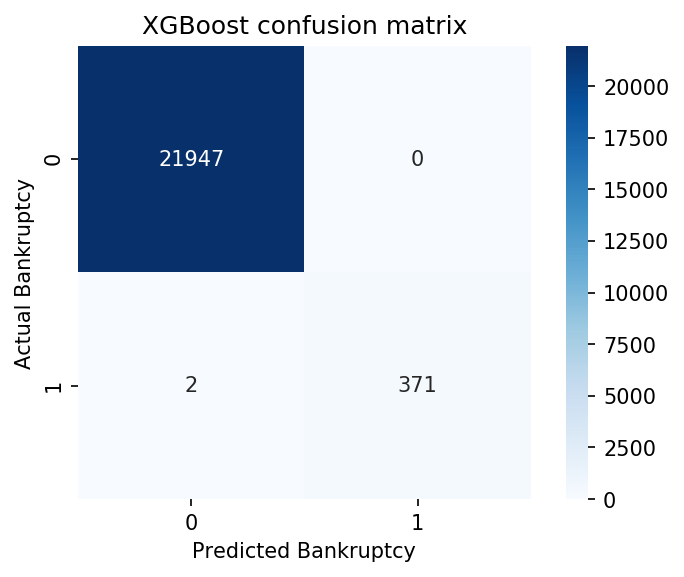

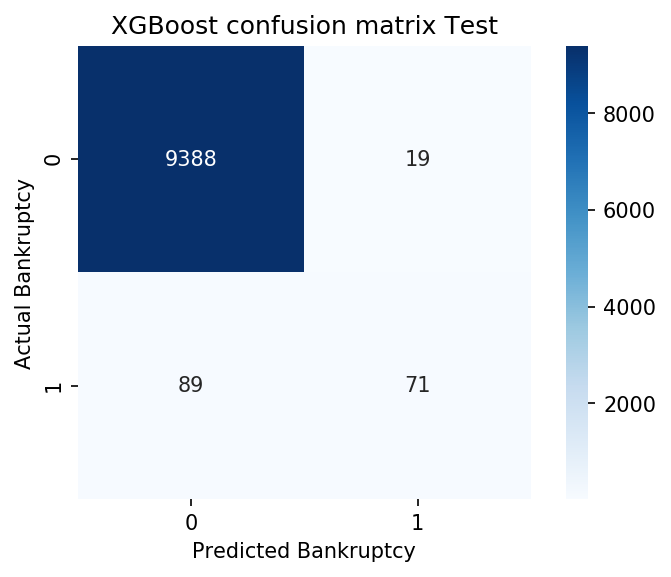

In [110]:
param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .8,
 'max_delta_step': 3,
 'max_depth': 6,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train , xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix Test');

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

In [111]:
print(f1_score(y_test, xgb.predict(X_test), average='macro'))
print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))

0.7811404363482313
recall:  0.44375


In [43]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=3).fit_transform(X_train)


# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
X_filled_nnm = NuclearNormMinimization().fit_transform(X_train)

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
X_incomplete_normalized = BiScaler().fit_transform(X_train)
X_filled_softimpute = SoftImpute().fit_transform(X_train)

Imputing row 1/24474 with 36 missing, elapsed time: 344.738
Imputing row 101/24474 with 27 missing, elapsed time: 345.107
Imputing row 201/24474 with 21 missing, elapsed time: 345.454
Imputing row 301/24474 with 23 missing, elapsed time: 345.801
Imputing row 401/24474 with 22 missing, elapsed time: 346.172
Imputing row 501/24474 with 22 missing, elapsed time: 346.539
Imputing row 601/24474 with 19 missing, elapsed time: 346.882
Imputing row 701/24474 with 25 missing, elapsed time: 347.228
Imputing row 801/24474 with 23 missing, elapsed time: 347.598
Imputing row 901/24474 with 37 missing, elapsed time: 347.956
Imputing row 1001/24474 with 36 missing, elapsed time: 348.312
Imputing row 1101/24474 with 28 missing, elapsed time: 348.675
Imputing row 1201/24474 with 36 missing, elapsed time: 349.051
Imputing row 1301/24474 with 20 missing, elapsed time: 349.396
Imputing row 1401/24474 with 32 missing, elapsed time: 349.764
Imputing row 1501/24474 with 16 missing, elapsed time: 350.123
Impu

Imputing row 13001/24474 with 37 missing, elapsed time: 391.355
Imputing row 13101/24474 with 24 missing, elapsed time: 391.720
Imputing row 13201/24474 with 23 missing, elapsed time: 392.069
Imputing row 13301/24474 with 22 missing, elapsed time: 392.428
Imputing row 13401/24474 with 22 missing, elapsed time: 392.784
Imputing row 13501/24474 with 24 missing, elapsed time: 393.150
Imputing row 13601/24474 with 27 missing, elapsed time: 393.525
Imputing row 13701/24474 with 26 missing, elapsed time: 393.891
Imputing row 13801/24474 with 22 missing, elapsed time: 394.244
Imputing row 13901/24474 with 23 missing, elapsed time: 394.609
Imputing row 14001/24474 with 30 missing, elapsed time: 394.974
Imputing row 14101/24474 with 18 missing, elapsed time: 395.338
Imputing row 14201/24474 with 17 missing, elapsed time: 395.681
Imputing row 14301/24474 with 26 missing, elapsed time: 396.025
Imputing row 14401/24474 with 24 missing, elapsed time: 396.373
Imputing row 14501/24474 with 31 missing

SolverError: The solver CVXOPT is not installed.

In [46]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
# that still matches observed values. Slow!
X_incomplete_normalized = BiScaler().fit_transform(X_train)
X_filled_softimpute = SoftImpute().fit_transform(X_train)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [51]:
param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 15,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_filled_knn,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

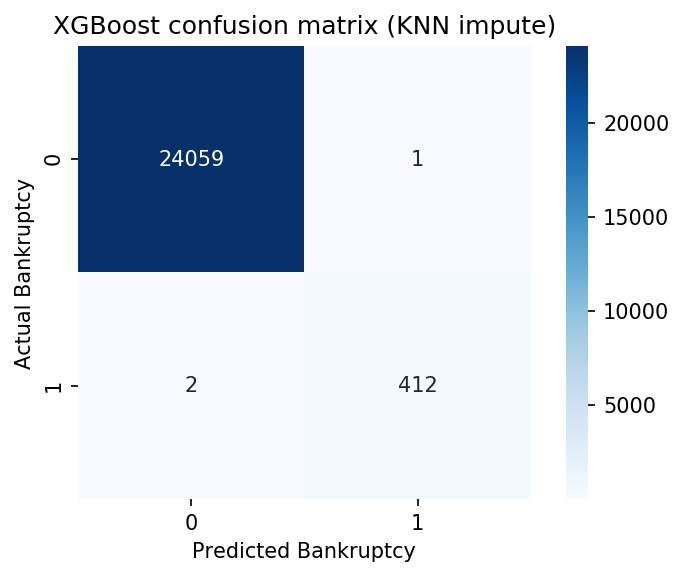

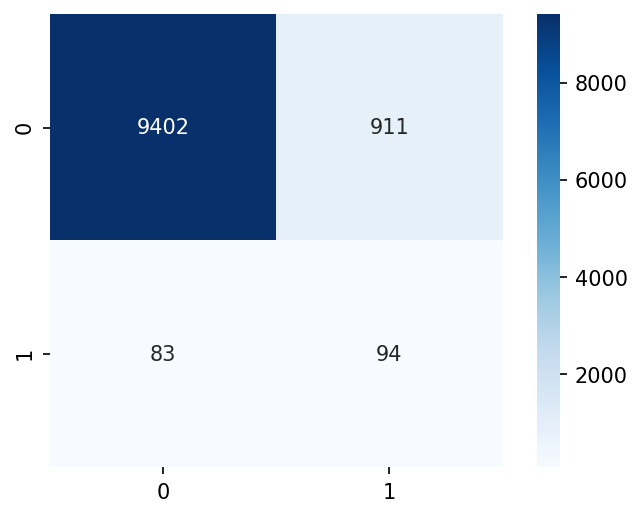

In [75]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_filled_knn))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(np.array(X_test)))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

In [113]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
oversample = SMOTE()
X_knn_smote, y_train_smote = oversample.fit_resample(X_filled_knn, y_train)
# summarize the new class distribution
counter = Counter(y_train_smote)

NameError: name 'X_filled_knn' is not defined

# Adding SMOTE oversampling.

In [114]:
param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 15,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_knn_smote,y_train_smote )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_knn_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(np.array(X_test)))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

NameError: name 'X_knn_smote' is not defined

# just smote

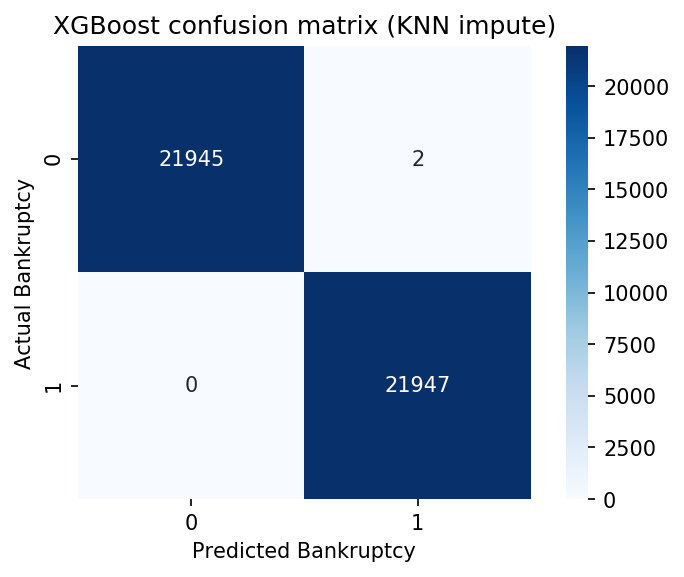

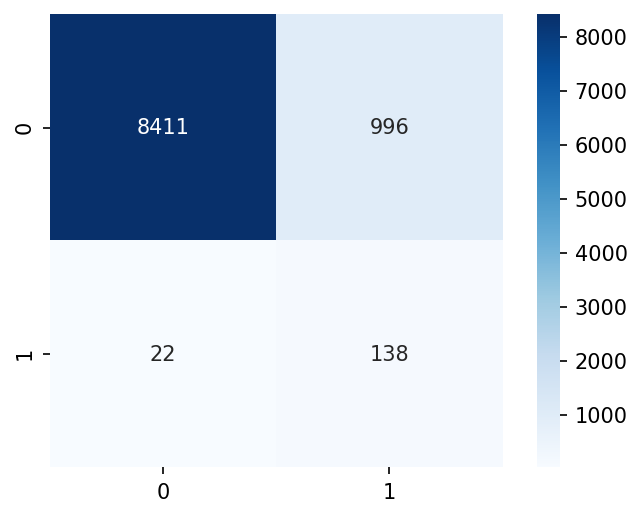

In [122]:
oversample = SMOTE()
X_train_0s = X_train.fillna(0)

X_train_smote, y_train_smote = oversample.fit_resample(X_train_0s, y_train)
# summarize the new class distribution
counter = Counter(y_train_smote)

param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .8,
 'max_delta_step': 3,
 'max_depth': 6,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train_smote,y_train_smote )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

Using Smote gave better recall but generally at a large loss to precision. resulted in an f1 score of about .52

In [117]:
print(f1_score(y_test, xgb.predict(X_test), average='macro'))
print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))

0.5513768651015939
recall:  0.9


# adjusting sampling to be less extreme than a 50/50 split.

A paper I had found [here](https://arxiv.org/pdf/1106.1813.pdf) explains that in the case of highly imbalanced data it can be best to undersample the majority class while expanding the minority class using SMOTE. They also mention this approach can be particularly effective if the cost of an incorrect majority classification is less costly than and minority misclassification. In our case, staying away from companies that don't end up going bankrupt is not a huge cost to us, however incorrectly predicting a company won't, and investing in it before it does can be very costly.

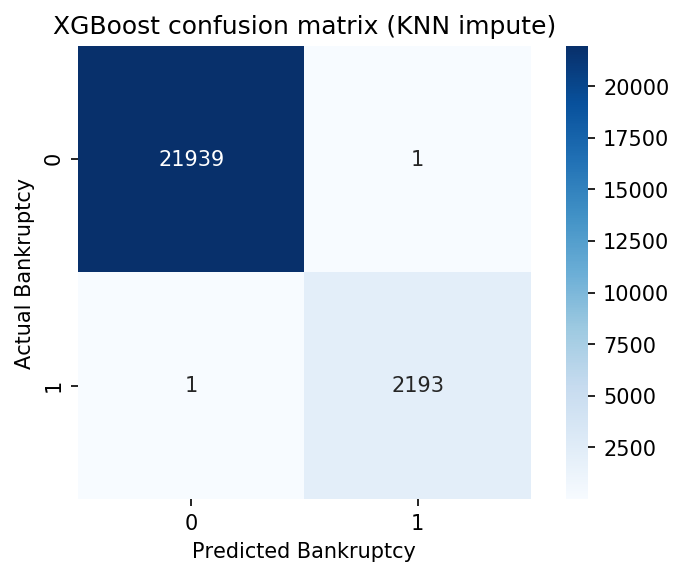

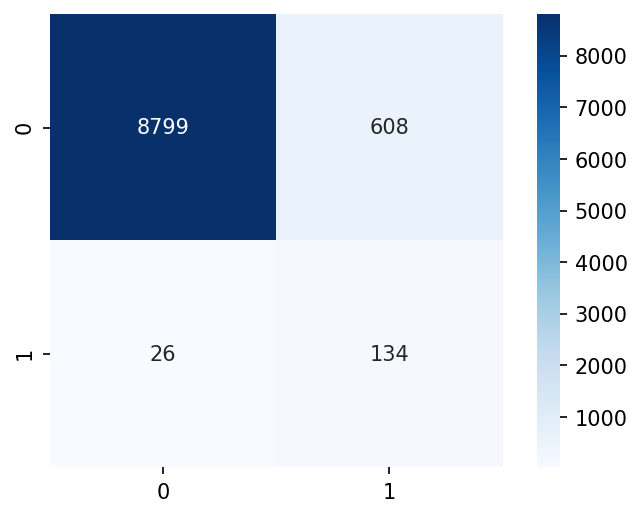

In [118]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)
# summarize the new class distribution
counter = Counter(y_train_smote)

param_dict={'base_score':.2 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .1,
 'max_delta_step': 6,
 'max_depth': 3,
 'min_child_weight': 6,
 'missing': None,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train_smote,y_train_smote )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

In [119]:
counter

Counter({0: 21940, 1: 2194})

In [120]:
print('f1 score: ',f1_score(y_test, xgb.predict(X_test), average='binary'))
print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))

f1 score:  0.29711751662971175
recall:  0.8375


# Adding some additional features.

In [9]:
base_dat['liquidity_ratio'] = np.nanmean(base_dat[['current assets','total current assets']].replace(0,np.nan),axis=1) / np.nanmean(base_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1)
base_dat['debt_to_equity'] = np.nanmean(base_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1) / base_dat['total stockholders equity']
base_dat['debt_ratio'] =   np.nanmean(base_dat[['longterm debt','current portion of longterm debt']].replace(0,np.nan),axis=1)  /np.nanmean(base_dat[['current assets','total current assets']].replace(0,np.nan),axis=1)
base_dat.replace(np.inf, 0, inplace=True)

Mean of empty slice
Mean of empty slice
Mean of empty slice


2        0.991091
3        1.209172
4        1.525238
5        1.506041
6        1.457771
           ...   
34959    1.887800
34960    1.737367
34961    1.904829
34962    1.944671
34963    1.855076
Name: liquidity_ratio, Length: 31887, dtype: float64

In [288]:
X_cols = X_cols+['liquidity_ratio','debt_to_equity','debt_ratio']
X = base_dat[X_cols]
y=base_dat['banruptcy_6_mo']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.3, random_state=2, stratify=y)

False

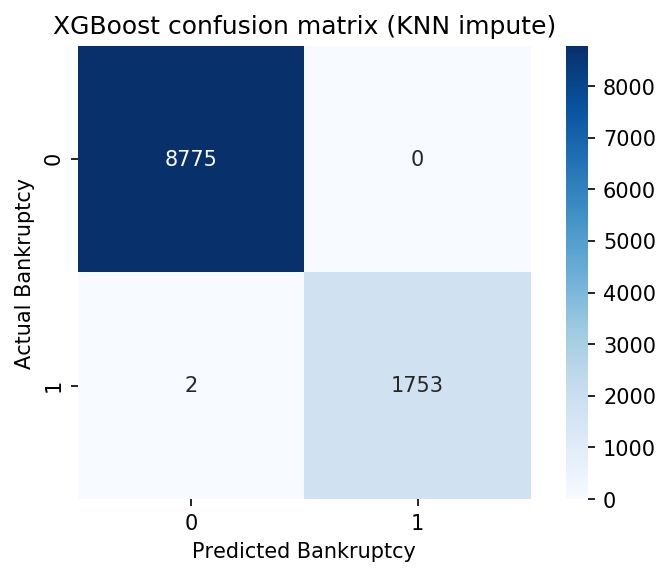

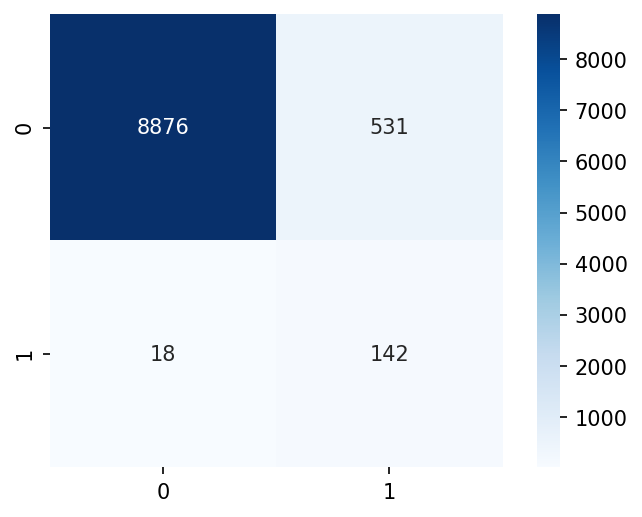

In [160]:
#rerun our model from before but with new features
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.08)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)

param_dict={'base_score':.2 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .8,
 'max_delta_step': 6,
 'max_depth': 6,
 'min_child_weight': 15,
 'missing': None,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_train_smote,y_train_smote )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

#plt.xlabel('Predicted Bankruptcy')
#plt.ylabel('Actual Bankruptcy')
#plt.title('XGBoost confusion matrix (KNN impute) TEST');

In [174]:
print('f1 score: ',f1_score(y_test, xgb.predict(X_test), average='binary'))
print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))

f1 score:  0.34093637454981995
recall:  0.8875


In [343]:

param_dict={'base_score':.2 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .8,
 'max_delta_step': 6,
 'max_depth': 6,
 'min_child_weight': 15,
 'missing': None,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()

kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(xgb,X_train_smote,y_train_smote, cv=kfold,scoring='recall')

#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
#print('f1 score: ',f1_score(y_test, xgb.predict(X_test), average='binary'))
#print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 94.15% (6.88%)


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

Text(0.5, 0, 'Xgboost Feature Importance')

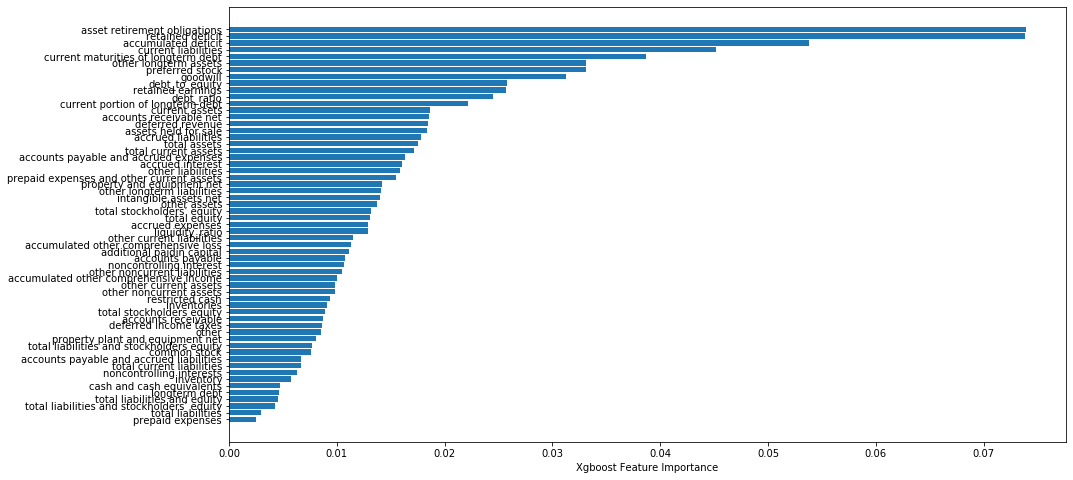

In [304]:
fig, ax = plt.subplots(figsize=(15, 8))
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [363]:
from sklearn.model_selection import GridSearchCV
xgb = xgboost.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1,.5,1], #so called `eta` value
              'max_depth': [3,9,12,15],
              'min_child_weight': [5,10,20],
              'silent': [1],
              'subsample': [0.8,0.9],
              'colsample_bytree': [0.7,0.9,1],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [10]}


clf = GridSearchCV(xgb, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='recall',
                   verbose=2, refit=True)

clf.fit(X_train_smote, y_train_smote)

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(X_test,y_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 10.1min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 17.5min
[Parallel(n_jobs=5)]: Done 810 out of 810 | elapsed: 20.9min finished


[15:16:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [368]:
clf.cv_results_['params'][clf.best_index_]

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'missing': -999,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 10,
 'silent': 1,
 'subsample': 0.8}

In [123]:
from sklearn.model_selection import GridSearchCV
xgb = xgboost.XGBClassifier()


parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.001,0.01,.05,.1], #so called `eta` value
              'max_depth': [3],
              'min_child_weight': [1,3,5],
              'silent': [1],
              'subsample': [.5,0.8],
              'colsample_bytree': [0.9,.95],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[100],
              'seed': [10]}


clf = GridSearchCV(xgb, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='recall',
                   verbose=2, refit=True)

clf.fit(X_train_smote, y_train_smote)

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(X_test,y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 17.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 78.5min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed: 120.8min finished


[19:00:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [380]:
clf.cv_results_

{'mean_fit_time': array([11.96200013, 12.5267993 , 11.48119988, 12.44900026, 11.38719978,
        12.74979963, 12.71740022, 12.94720068, 12.54500008, 13.74742646,
        13.42551255, 13.08579888, 12.34719911, 13.07559919, 11.66759977,
        12.80520053, 11.08839989, 11.48300109, 11.06740036, 15.44640064,
        15.6009994 , 14.85490284, 11.56120009, 14.6004005 , 15.56480036,
        16.19772778, 15.01999998, 15.73794723, 14.60860019, 16.0272016 ,
        14.18145866, 16.36403103, 14.6138011 , 15.63211842, 14.1644526 ,
        15.44861565, 15.94073076, 17.0945178 , 19.77360983, 15.80020037,
        13.94839959, 15.3099999 , 14.87603221, 16.31483088, 14.58940029,
        15.35744328, 14.27822924, 14.67077351]),
 'std_fit_time': array([0.04918071, 0.03921907, 0.03258472, 0.03978479, 0.03166416,
        0.07475684, 0.04293557, 0.04201626, 0.01650509, 0.07493182,
        0.05062369, 0.05682038, 0.04922409, 0.02653734, 0.02710506,
        0.02968763, 0.05698629, 0.03986499, 0.07330655, 0

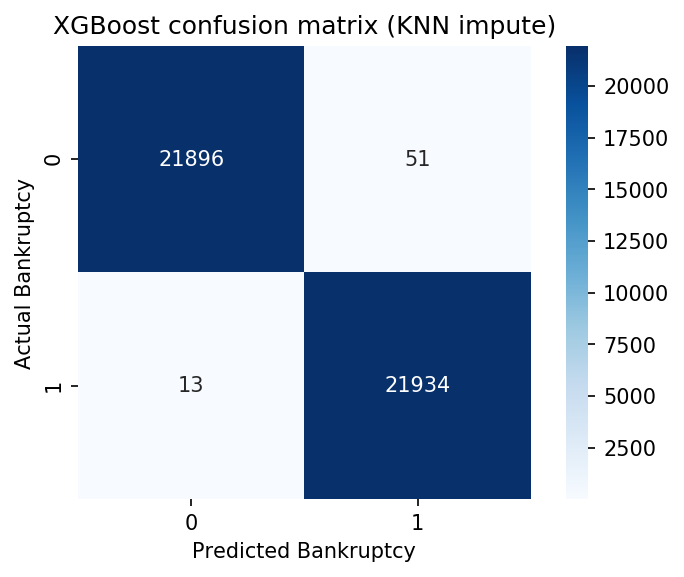

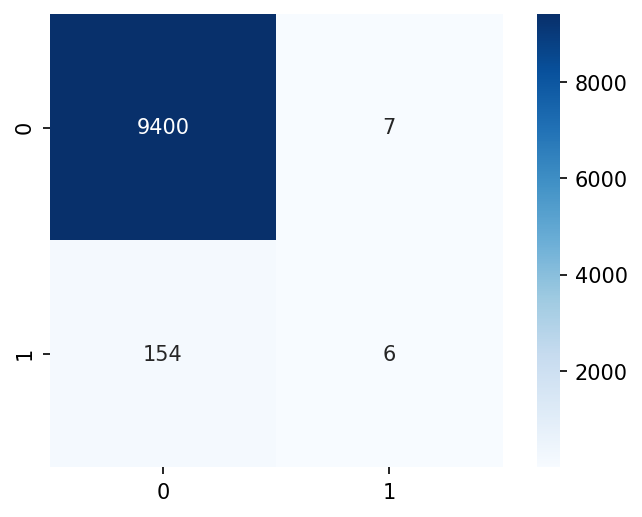

In [124]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , clf.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, clf.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')


In [125]:
print(clf.best_params_)

{'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'missing': 100, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 10, 'silent': 1, 'subsample': 0.5}


In [371]:
# Add difference over time values.
base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)

base_dat.to_csv('table_cleaning.csv')

#make file type change columns
for col in X_cols:
    base_dat[col+'_diff']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1),base_dat[col]-base_dat[col].shift(1),0)


#make file type change columns
for col in X_cols:
    base_dat[col+'_cumsum']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1), base_dat[col+'_diff'].shift(1),0)

base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)
for col in X_cols:
    for l in range(1,len(base_dat)):
        base_dat.loc[l,col+'_cumsum']= np.where(base_dat.loc[l,'Filings']==base_dat.loc[l-1,'Filings'], base_dat.loc[l-1,col+'_cumsum']+base_dat.loc[l,col+'_diff'],0)


In [372]:
base_dat[base_dat.CIK==1750][['Filings','current assets','current assets_diff','current assets_cumsum']]

,Filings,current assets,current assets_diff,current assets_cumsum
0,10-K,1116.900000,0.000000,0.000000
1,10-K,954.100000,-162.800000,-162.800000
2,10-K,873.100000,-81.000000,-243.800000
3,10-K,888.500000,15.400000,-228.400000
4,10-K,362.600000,-525.900000,-754.300000
5,10-K,355.400000,-7.200000,-761.500000
6,10-Q,1082.500000,0.000000,0.000000
7,10-Q,1126.900000,44.400000,44.400000
8,10-Q,1155.900000,29.000000,73.400000
9,10-Q,1214.800000,58.900000,132.300000


In [140]:
diff_cols = [s + '_diff' for s in X_cols]

cum_cols = [s + '_cumsum' for s in X_cols]

X = base_dat[X_cols]
y=base_dat['banruptcy_6_mo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

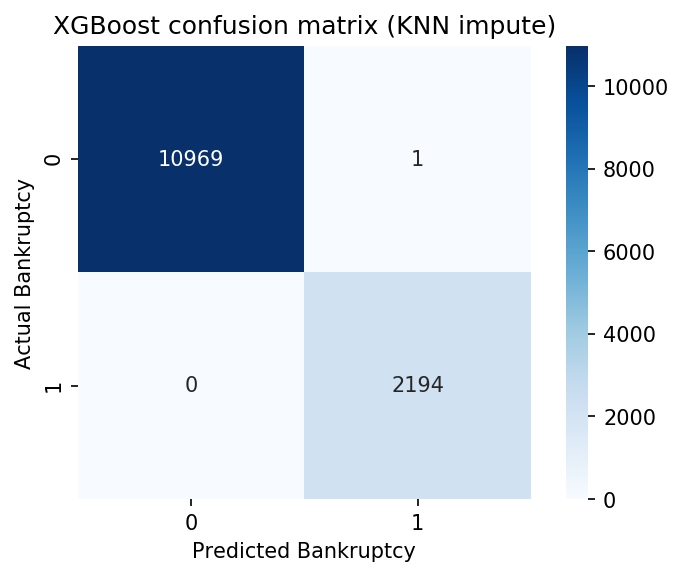

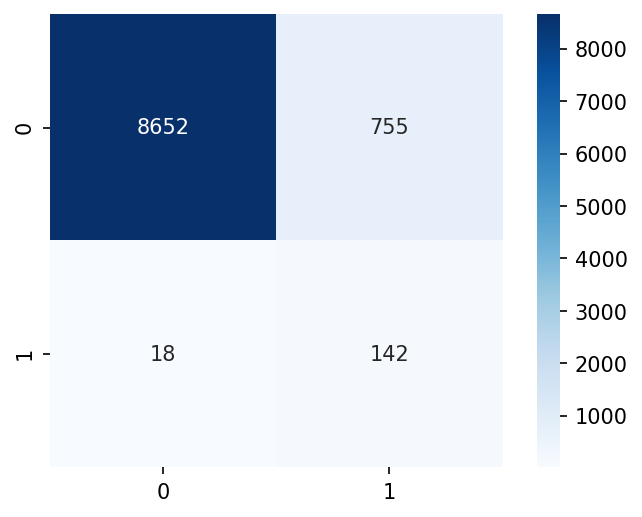

In [141]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_0s = X_train.fillna(0)

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_0s, y_train)
# summarize the new class distribution
counter = Counter(y_train_smote)

param_dict={'base_score':.5 ,
 'scale_pos_weight': 10,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': .3,
 'max_delta_step': 6,
 'max_depth': 3,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 10000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier(**param_dict,n_jobs=2)


xgb.fit(X_train_smote,y_train_smote, early_stopping_rounds=150,eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)],eval_metric='aucpr',verbose=False )

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train_smote , xgb.predict(X_train_smote))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

In [155]:
print('f1 score: ',f1_score(y_test, xgb.predict(X_test), average='binary'))
print('recall: ',recall_score(y_test, xgb.predict(X_test),average="binary"))

f1 score:  0.26868495742667925
recall:  0.8875


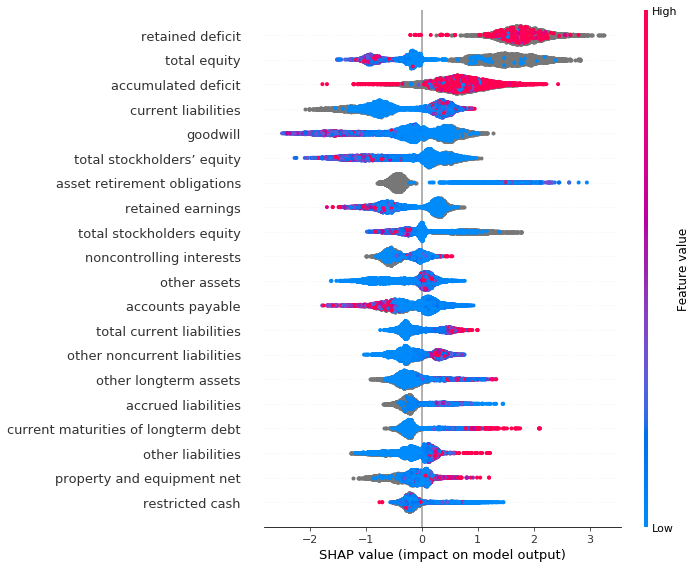

In [175]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

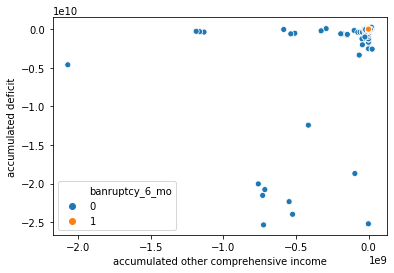

In [427]:
sns.scatterplot('accumulated other comprehensive income','accumulated deficit', hue='banruptcy_6_mo', data=base_dat)

In [162]:
base_dat['prdicted'] = xgb.predict(X)

In [163]:
base_dat[base_dat.prdicted==1][['CIK','Name','Filings','Filing Date','prdicted','banruptcy_6_mo','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,prdicted,banruptcy_6_mo,d_to_bankruptcy
50,2034,Aceto Corporation,10-K,2017-08-25,1,0,543.0
51,2034,Aceto Corporation,10-K,2018-09-28,1,1,144.0
52,2034,Aceto Corporation,10-K/A,2017-11-09,1,0,467.0
53,2034,Aceto Corporation,10-Q,2017-02-03,1,0,746.0
54,2034,Aceto Corporation,10-Q,2017-05-05,1,0,655.0
...,...,...,...,...,...,...,...
31882,1722287,Covia Holdings Corporation,10-Q,2019-11-06,1,1,236.0
31883,1735707,Garrett Motion Inc.,10-Q,2018-11-06,1,0,684.0
31884,1735828,Legacy Reserves Inc.,10-K,2019-03-22,1,1,88.0
31885,1735828,Legacy Reserves Inc.,10-Q,2018-10-31,1,1,230.0


In [177]:
# Something interesting to look at. If we say the model correctly assumes a company will go bankrupt, even early, how often does that happen.?

mask = (base_dat['prdicted']==1) & (base_dat['d_to_bankruptcy']!=0)& (base_dat['banruptcy_6_mo']==0)
base_dat[mask]

,level_0,index,CIK,Ticker,Name,Filings,Description,Filing Date,File/Film Number,links,...,retained deficit_cumsum,accounts payable and accrued liabilities_cumsum,accrued liabilities_cumsum,accounts receivable_cumsum,other current liabilities_cumsum,liquidity_ratio_cumsum,debt_to_equity_cumsum,debt_ratio_cumsum,predict,prdicted
50,37009,38371,2034,NaN,Aceto Corporation,10-K,"Annual report [Section 13 and 15(d), not S-K I...",2017-08-25,000-04217171050831,/Archives/edgar/data/2034/000114420417045100/0...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
52,37007,38369,2034,NaN,Aceto Corporation,10-K/A,"[Amend] Annual report [Section 13 and 15(d), n...",2017-11-09,000-04217171191924,/Archives/edgar/data/2034/000114420417057835/0...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
53,37011,38373,2034,NaN,Aceto Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2017-02-03,000-0421717571099,/Archives/edgar/data/2034/000157104917000995/0...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
54,37010,38372,2034,NaN,Aceto Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2017-05-05,000-0421717817044,/Archives/edgar/data/2034/000157104917004520/0...,...,NaN,NaN,NaN,NaN,24447.0,-0.035732,0.019459,-0.028627,0,1
55,37008,38370,2034,NaN,Aceto Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2017-11-03,000-04217171176367,/Archives/edgar/data/2034/000114420417056166/0...,...,NaN,NaN,NaN,NaN,19523.0,-0.009925,-0.006904,-0.052632,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31876,37427,38866,1722287,NaN,Covia Holdings Corporation,10-K,"Annual report [Section 13 and 15(d), not S-K I...",2019-03-22,001-3851019700813,/Archives/edgar/data/1722287/00015645901900904...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1
31878,37429,38868,1722287,NaN,Covia Holdings Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2018-08-14,001-38510181018956,/Archives/edgar/data/1722287/00015645901802175...,...,NaN,NaN,NaN,NaN,-65374.0,-2.127131,NaN,0.705360,1,1
31879,37428,38867,1722287,NaN,Covia Holdings Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2018-11-14,001-38510181183889,/Archives/edgar/data/1722287/00015645901802957...,...,NaN,NaN,NaN,NaN,-92787.5,-1.703923,NaN,0.804177,1,1
31880,37426,38865,1722287,NaN,Covia Holdings Corporation,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2019-05-09,001-3851019811853,/Archives/edgar/data/1722287/00015645901901811...,...,NaN,NaN,NaN,NaN,-70512.0,-1.899464,NaN,0.819881,1,1


In [180]:
X_test

,current assets,cash and cash equivalents,accounts receivable net,prepaid expenses,other current assets,total current assets,property and equipment net,goodwill,other assets,total assets,...,deferred revenue,other,accrued interest,inventory,asset retirement obligations,retained deficit,accounts payable and accrued liabilities,accrued liabilities,accounts receivable,other current liabilities
31355,NaN,NaN,NaN,NaN,7.331230e+05,3.571076e+07,NaN,74056.0,18221944.0,1.822194e+07,...,NaN,NaN,38529.0,NaN,NaN,NaN,429531.0,NaN,326640.0,197969.000000
10665,4245.0,870.0,NaN,NaN,2.240000e+03,4.692333e+03,1161.0,388.0,3673.0,3.863667e+03,...,NaN,NaN,NaN,1613.0,NaN,NaN,NaN,NaN,NaN,2721.000000
5819,NaN,NaN,NaN,NaN,3.024000e+03,1.043900e+05,NaN,3958.0,53707.0,5.370700e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5652.000000
10126,12793.0,8225.0,7407.0,NaN,1.112467e+04,2.580750e+04,5260.0,15573.0,22452.0,2.976867e+04,...,NaN,NaN,NaN,4600.0,NaN,NaN,NaN,6717.0,7407.0,13400.500000
14464,333678.5,244455.0,136779.0,NaN,3.336785e+05,4.355288e+05,152263.0,NaN,494001.5,8.002040e+05,...,NaN,NaN,NaN,52686.0,NaN,NaN,NaN,71452.0,136779.0,63311.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30630,118775.0,33178.0,38400.0,NaN,6.837250e+04,8.193423e+05,2313657.5,66278.0,1051876.0,7.408423e+05,...,79554.0,NaN,NaN,30887.0,NaN,NaN,NaN,NaN,38400.0,147353.500000
19337,398468.0,77272.0,NaN,NaN,2.043755e+05,4.595243e+05,98428.0,210009.0,429764.0,4.193320e+05,...,NaN,NaN,NaN,161750.0,NaN,NaN,NaN,NaN,NaN,76280.500000
28350,512028.0,171670.0,NaN,NaN,2.596440e+05,6.244490e+05,723813.0,NaN,546943.5,5.353050e+05,...,40466.0,25176.0,NaN,267766.0,NaN,NaN,NaN,NaN,NaN,185972.000000
11314,1213186.0,204455.0,NaN,NaN,1.213186e+06,1.934066e+06,1596917.0,525044.0,2550269.5,2.104575e+06,...,75170.0,12817.0,NaN,NaN,NaN,NaN,NaN,NaN,52174.0,633690.000000


In [178]:
np.mean(base_dat[mask]['d_to_bankruptcy'])

583.5012285012285

## of our 531 incorrect predictions of bankruptcy, 407 of them did file for bankruptcy eventually.

In [181]:
mask = (base_dat['prdicted']==0) & (base_dat['d_to_bankruptcy']!=0)& (base_dat['banruptcy_6_mo']==1)
base_dat[mask][['CIK','Name','Filings','Filing Date','prdicted','banruptcy_6_mo','d_to_bankruptcy']].head(30)

,CIK,Name,Filings,Filing Date,prdicted,banruptcy_6_mo,d_to_bankruptcy
935,14195,Briggs & Stratton Corporation,10-K,2019-08-27,0,1,328.0
1188,18172,A. M. Castle & Co.,10-K,2017-04-07,0,1,72.0
2674,38984,"Real Industry, Inc.",10-Q,2017-08-08,0,1,101.0
7774,278041,International Shipholding Corporation,10-Q,2015-08-03,0,1,364.0
8238,351817,Swift Energy Company,10-K,2015-03-02,0,1,304.0
10990,813920,"CEC Entertainment, Inc.",10-Q,2019-11-12,0,1,225.0
15785,945436,"SunEdison, Inc.",10-Q,2015-05-07,0,1,350.0
17771,1045425,RAIT Financial Trust,10-K,2019-03-26,0,1,157.0
17774,1045425,RAIT Financial Trust,10-Q,2018-11-08,0,1,295.0
18687,1065059,USEC Inc.,10-Q,2013-11-05,0,1,120.0


In [204]:
base_dat[base_dat.Name=='Aeropostale, Inc.'][['CIK','Name','Filings','Filing Date','prdicted','banruptcy_6_mo','d_to_bankruptcy']].sort_values('Filing Date').head(30)

,CIK,Name,Filings,Filing Date,prdicted,banruptcy_6_mo,d_to_bankruptcy
21282,1168213,"Aeropostale, Inc.",10-K,2014-04-04,0,0,761.0
21284,1168213,"Aeropostale, Inc.",10-Q,2014-06-09,0,0,695.0
21285,1168213,"Aeropostale, Inc.",10-Q,2014-09-08,0,0,604.0
21286,1168213,"Aeropostale, Inc.",10-Q,2014-12-08,0,0,513.0
21283,1168213,"Aeropostale, Inc.",10-K,2015-03-30,0,0,401.0
21287,1168213,"Aeropostale, Inc.",10-Q,2015-06-11,1,1,328.0
21288,1168213,"Aeropostale, Inc.",10-Q,2015-09-08,0,1,239.0
21289,1168213,"Aeropostale, Inc.",10-Q,2015-12-07,1,1,149.0


In [153]:
base_dat[base_dat.Name=='Real Industry, Inc.'][X_cols]

,current assets,cash and cash equivalents,accounts receivable net,prepaid expenses,other current assets,total current assets,property and equipment net,goodwill,other assets,total assets,...,deferred revenue,other,accrued interest,inventory,asset retirement obligations,retained deficit,accounts payable and accrued liabilities,accrued liabilities,accounts receivable,other current liabilities
2664,30.016333,62.868,4.509,NaN,22.751250,45.4282,NaN,17780.0,62.0255,104.01,...,NaN,NaN,NaN,11.349,NaN,NaN,6218.0,NaN,4.509,5.487
2665,140.000000,35.700,77.200,NaN,140.000000,284.0000,301.5,104.3,700.9000,486.35,...,NaN,NaN,NaN,101.200,NaN,NaN,NaN,51.8,77.200,80.250
2666,148.300000,27.200,88.400,NaN,148.300000,276.6500,289.2,42.2,645.5000,466.15,...,NaN,NaN,NaN,118.200,NaN,NaN,NaN,46.4,88.400,85.700
2667,119.200000,28.600,170.700,NaN,105.000000,273.4000,316.4,102.3,400.4500,568.20,...,NaN,NaN,NaN,136.100,NaN,NaN,NaN,37.7,170.700,97.300
2668,43.366667,8.800,18.500,NaN,43.366667,86.8400,106.6,NaN,118.3500,180.15,...,NaN,NaN,NaN,44.100,NaN,NaN,NaN,15.3,18.500,35.800
2669,44.000000,16.400,15.200,NaN,44.000000,86.8400,104.6,NaN,118.3000,180.50,...,NaN,NaN,NaN,45.200,NaN,NaN,NaN,13.1,15.200,35.050
2670,49.700000,5.400,17.000,NaN,49.700000,89.9500,99.8,9.3,208.5000,152.95,...,NaN,NaN,NaN,32.500,NaN,NaN,NaN,15.6,17.000,26.950
2671,50.600000,5.300,16.000,NaN,50.600000,90.6750,97.2,9.1,207.5000,153.35,...,NaN,NaN,NaN,31.100,NaN,NaN,NaN,12.0,16.000,27.900
2672,53.300000,5.800,16.200,NaN,53.300000,93.8250,97.4,9.2,213.2000,158.50,...,NaN,NaN,NaN,29.700,NaN,NaN,NaN,14.1,16.200,28.650
2673,50.900000,4.400,17.800,NaN,50.900000,92.6000,96.6,8.8,207.2000,152.70,...,NaN,NaN,NaN,36.900,NaN,NaN,NaN,16.2,17.800,31.600


In [515]:
base_dat[base_dat.Name=='Pier 1 Imports, Inc.'][['CIK','Name','Filings','Filing Date','prdicted','banruptcy_6_mo','d_to_bankruptcy']].head(30)

,CIK,Name,Filings,Filing Date,prdicted,banruptcy_6_mo,d_to_bankruptcy
7777,278130,"Pier 1 Imports, Inc.",10-K,2018-05-02,0,0,656.0
7778,278130,"Pier 1 Imports, Inc.",10-K,2019-04-29,0,1,294.0
7779,278130,"Pier 1 Imports, Inc.",10-Q,2018-01-03,0,0,775.0
7780,278130,"Pier 1 Imports, Inc.",10-Q,2018-07-11,1,0,586.0
7781,278130,"Pier 1 Imports, Inc.",10-Q,2018-10-10,1,0,495.0
7782,278130,"Pier 1 Imports, Inc.",10-Q,2019-01-09,1,0,404.0
7783,278130,"Pier 1 Imports, Inc.",10-Q,2019-07-10,1,1,222.0
7784,278130,"Pier 1 Imports, Inc.",10-Q,2019-10-09,1,1,131.0


# Well we have had some interesting things come from this. Now Lets try the holdout data from 2020.

In [517]:
holdout['liquidity_ratio'] = np.nanmean(holdout[['current assets','total current assets']].replace(0,np.nan),axis=1) / np.nanmean(holdout[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1)
holdout['debt_to_equity'] = np.nanmean(holdout[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1) / holdout['total stockholders equity']
holdout['debt_ratio'] =   np.nanmean(holdout[['longterm debt','current portion of longterm debt']].replace(0,np.nan),axis=1)  /np.nanmean(holdout[['current assets','total current assets']].replace(0,np.nan),axis=1)
holdout.replace(np.inf, 0, inplace=True)

Mean of empty slice
Mean of empty slice
Mean of empty slice


In [518]:
# Add difference over time values.
holdout = holdout.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)

#make file type change columns
for col in X_cols:
    holdout[col+'_diff']= np.where(holdout['Filings']==holdout['Filings'].shift(1),holdout[col]-holdout[col].shift(1),0)


#make file type change columns
for col in X_cols:
    holdout[col+'_cumsum']= np.where(holdout['Filings']==holdout['Filings'].shift(1), holdout[col+'_diff'].shift(1),0)

holdout = holdout.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)
for col in X_cols:
    for l in range(1,len(holdout)):
        holdout.loc[l,col+'_cumsum']= np.where(holdout.loc[l,'Filings']==holdout.loc[l-1,'Filings'], holdout.loc[l-1,col+'_cumsum']+holdout.loc[l,col+'_diff'],0)


In [167]:
holdout[X_cols].head(20)

,current assets,cash and cash equivalents,accounts receivable net,prepaid expenses,other current assets,total current assets,property and equipment net,goodwill,other assets,total assets,...,deferred revenue,other,accrued interest,inventory,asset retirement obligations,retained deficit,accounts payable and accrued liabilities,accrued liabilities,accounts receivable,other current liabilities
0,532.466667,404.7,171.9,NaN,532.466667,811.900000,382.2,115.7,8.869333e+02,1340.766667,...,NaN,NaN,NaN,623.1,NaN,NaN,NaN,161.6,171.9,403.600000
1,441.633333,37.0,NaN,NaN,441.633333,727.820000,NaN,116.5,8.163000e+02,1173.700000,...,NaN,NaN,NaN,621.6,NaN,NaN,NaN,149.8,NaN,308.800000
2,412.533333,107.7,NaN,NaN,412.533333,669.140000,NaN,NaN,7.626667e+02,1100.200000,...,NaN,NaN,NaN,597.7,NaN,NaN,NaN,145.0,NaN,286.266667
3,15667.000000,3860.0,NaN,NaN,15667.000000,31472.333333,12418.5,23195.0,6.788700e+04,41777.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4035.0,NaN,7449.000000
4,15498.000000,3377.0,NaN,NaN,15498.000000,31027.666667,12307.0,22927.0,6.677700e+04,41137.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4408.0,NaN,7608.000000
5,17221.000000,4763.0,NaN,NaN,17221.000000,32318.666667,12858.5,23082.0,6.877600e+04,42998.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4206.0,NaN,7582.500000
6,4597.000000,1466.0,1859.0,NaN,1683.333333,4328.000000,500.0,289.0,3.203500e+03,3668.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1084.0,1859.0,863.333333
7,4390.000000,1330.0,1691.0,NaN,1610.333333,4079.666667,540.0,289.0,3.115000e+03,3540.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.0,1691.0,734.333333
8,2717.500000,1775.0,1789.0,NaN,1834.333333,3613.000000,585.0,289.0,6.583000e+03,5846.000000,...,NaN,NaN,NaN,1324.0,NaN,NaN,NaN,1172.0,1789.0,884.000000
9,6812.066667,2406.1,NaN,98.3,6812.066667,8381.360000,10692.2,816.1,1.965160e+04,12185.650000,...,NaN,NaN,NaN,400.6,NaN,NaN,1630.0,NaN,NaN,3182.833333


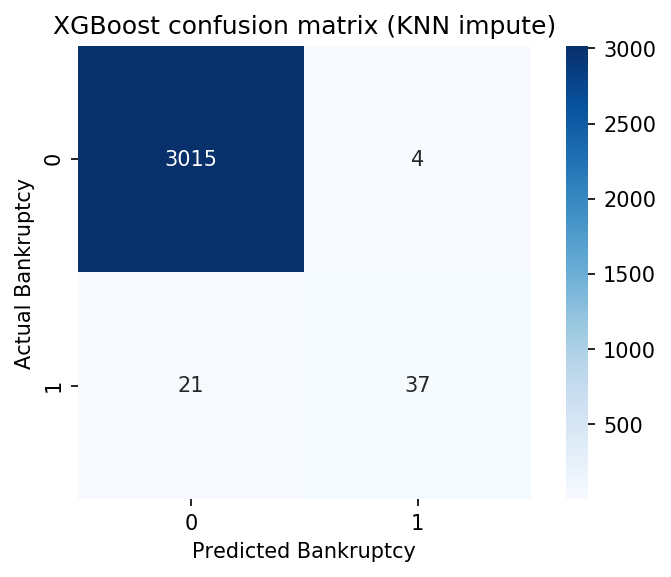

In [168]:
cum_cols = [s + '_cumsum' for s in X_cols]

X = holdout[X_cols].fillna(0)
y=holdout['banruptcy_6_mo']

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y, xgb.predict(X))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (KNN impute)');


In [527]:
holdout['predict']= xgb.predict(X)

In [169]:
mask = (holdout['predict']==0) & (holdout['d_to_bankruptcy']!=0)& (holdout['banruptcy_6_mo']==1)
holdout[mask][['CIK','Name','Filings','Filing Date','predict','banruptcy_6_mo','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,predict,banruptcy_6_mo,d_to_bankruptcy
12,3116,"Akorn, Inc.",10-K,2020-02-26,0,1,84.0
13,3116,"Akorn, Inc.",10-Q,2020-05-11,0,1,9.0
109,14195,Briggs & Stratton Corporation,10-Q,2020-02-04,0,1,167.0
110,14195,Briggs & Stratton Corporation,10-Q,2020-05-08,0,1,73.0
162,20520,Frontier Communications Corporation,10-K,2020-03-31,0,1,14.0
859,278130,"Pier 1 Imports, Inc.",10-Q,2020-01-06,0,1,42.0
884,314808,Valaris plc,10-K,2020-02-21,0,1,180.0
885,314808,Valaris plc,10-Q,2020-04-30,0,1,111.0
886,314808,Valaris plc,10-Q,2020-07-30,0,1,20.0
1169,813920,"CEC Entertainment, Inc.",10-K,2020-03-12,0,1,104.0


In [170]:
error_names = holdout[mask]['Name'].unique()
base_dat[(base_dat.Name.isin(error_names)) & (base_dat.prdicted==1)][['CIK','Name','Filings','Filing Date','prdicted','banruptcy_6_mo','d_to_bankruptcy']][60:100]

,CIK,Name,Filings,Filing Date,prdicted,banruptcy_6_mo,d_to_bankruptcy
28423,1486159,Oasis Petroleum Inc.,10-Q,2018-08-07,1,0,785.0
28424,1486159,Oasis Petroleum Inc.,10-Q,2018-11-06,1,0,694.0
28425,1486159,Oasis Petroleum Inc.,10-Q,2019-05-08,1,0,511.0
28426,1486159,Oasis Petroleum Inc.,10-Q,2019-08-09,1,0,418.0
28427,1486159,Oasis Petroleum Inc.,10-Q,2019-11-06,1,1,329.0
28865,1498301,"Ascena Retail Group, Inc.",10-K,2018-09-24,1,0,668.0
28868,1498301,"Ascena Retail Group, Inc.",10-Q,2018-12-10,1,0,591.0
28869,1498301,"Ascena Retail Group, Inc.",10-Q,2019-03-14,1,0,497.0
28870,1498301,"Ascena Retail Group, Inc.",10-Q,2019-12-10,1,1,226.0
29736,1529463,"FTS International, Inc.",10-Q,2019-11-05,1,1,322.0


#### While I have to figure out a better way to fix this checking system. It seems that a good amount of ones we have mislabeled were actually previously flagged. This could be because of the cut off before calculating some of the running sums...

Well than an interesting list of course would be companies we have flagged but are not in the bankruptcy data set. This could indicate future bankruptcy filings.

In [171]:
mask = (holdout['predict']==0) & (holdout['d_to_bankruptcy']!=0)& (holdout['banruptcy_6_mo']==1)
holdout[mask][['CIK','Name','Filings','Filing Date','predict','banruptcy_6_mo','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,predict,banruptcy_6_mo,d_to_bankruptcy
12,3116,"Akorn, Inc.",10-K,2020-02-26,0,1,84.0
13,3116,"Akorn, Inc.",10-Q,2020-05-11,0,1,9.0
109,14195,Briggs & Stratton Corporation,10-Q,2020-02-04,0,1,167.0
110,14195,Briggs & Stratton Corporation,10-Q,2020-05-08,0,1,73.0
162,20520,Frontier Communications Corporation,10-K,2020-03-31,0,1,14.0
859,278130,"Pier 1 Imports, Inc.",10-Q,2020-01-06,0,1,42.0
884,314808,Valaris plc,10-K,2020-02-21,0,1,180.0
885,314808,Valaris plc,10-Q,2020-04-30,0,1,111.0
886,314808,Valaris plc,10-Q,2020-07-30,0,1,20.0
1169,813920,"CEC Entertainment, Inc.",10-K,2020-03-12,0,1,104.0


In [173]:
mask = (holdout['predict']==1) & (holdout['d_to_bankruptcy']==0)
holdout[mask][['CIK','Name','Filings','Filing Date','predict','banruptcy_6_mo','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,predict,banruptcy_6_mo,d_to_bankruptcy
76,8868,Avon Products Inc,10-Q,2020-08-14,1,0,0.0
459,60714,LSB Industries Inc,10-Q,2020-07-31,1,0,0.0
769,101778,Marathon Oil Corp,10-Q,2020-08-06,1,0,0.0
1246,844965,Tetra Technologies Inc,10-Q,2020-08-07,1,0,0.0
1252,849636,Cortex Pharmaceuticals Inc,10-Q,2020-08-19,1,0,0.0
1269,858470,Cabot Oil & Gas Corp,10-K,2020-02-25,1,0,0.0
1387,886835,Superior Energy Services Inc,10-Q,2020-08-10,1,0,0.0
1419,893538,SM Energy Co,10-Q,2020-07-31,1,0,0.0
1477,899751,Titan International Inc,10-Q,2020-08-06,1,0,0.0
1601,928022,Callon Petroleum Co,10-Q,2020-08-05,1,0,0.0


In [12]:
import pickle
# save model to file
pickle.dump(xgb, open("bankruptcy_model.pickle.dat", "wb"))
base_dat.to_pickle('FINAL_TRAIN.pkl')
holdout.to_pickle('FINAL_HOLDOUT.pkl')

In [5]:
base_dat=pd.read_pickle('FINAL_TRAIN.pkl')
holdout=pd.read_pickle('FINAL_HOLDOUT.pkl')

In [14]:
base_dat.columns

Index(['level_0', 'index', 'CIK', 'Ticker', 'Name', 'Filings', 'Description',
       'Filing Date', 'File/Film Number', 'links',
       ...
       'asset retirement obligations_cumsum', 'retained deficit_cumsum',
       'accounts payable and accrued liabilities_cumsum',
       'accrued liabilities_cumsum', 'accounts receivable_cumsum',
       'other current liabilities_cumsum', 'liquidity_ratio_cumsum',
       'debt_to_equity_cumsum', 'debt_ratio_cumsum', 'predict'],
      dtype='object', length=195)

In [10]:
all_dat=pd.concat([base_dat,holdout])
all_dat['liquidity_ratio'] = np.nanmean(all_dat[['current assets','total current assets']].replace(0,np.nan),axis=1) / np.nanmean(all_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1)
all_dat['debt_to_equity'] = np.nanmean(all_dat[['current liabilities','total current liabilities']].replace(0,np.nan),axis=1) / all_dat['total stockholders equity']
all_dat['debt_ratio'] =   np.nanmean(all_dat[['longterm debt','current portion of longterm debt']].replace(0,np.nan),axis=1)  /np.nanmean(all_dat[['current assets','total current assets']].replace(0,np.nan),axis=1)
all_dat.replace(np.inf, 0, inplace=True)

Mean of empty slice
Mean of empty slice
Mean of empty slice


In [30]:
# Add difference over time values.
all_dat = all_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)

all_dat.to_csv('table_cleaning.csv')

#make file type change columns
for col in X_cols:
    all_dat[col+'_diff']= np.where(all_dat['Filings']==all_dat['Filings'].shift(1),all_dat[col]-all_dat[col].shift(1),0)


#make file type change columns
for col in X_cols:
    all_dat[col+'_cumsum']= np.where(all_dat['Filings']==all_dat['Filings'].shift(1), all_dat[col+'_diff'].shift(1),0)

all_dat = all_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)
for col in X_cols:
    for l in range(1,len(all_dat)):
        all_dat.loc[l,col+'_cumsum']= np.where(all_dat.loc[l,'Filings']==all_dat.loc[l-1,'Filings'], all_dat.loc[l-1,col+'_cumsum']+all_dat.loc[l,col+'_diff'],0)


In [49]:
from sklearn.manifold import TSNE
cum_cols = [s + '_cumsum' for s in X_cols]

X=all_dat[X_cols].fillna(0)

tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=1000,learning_rate=200)
tsne_results = tsne.fit_transform(X)

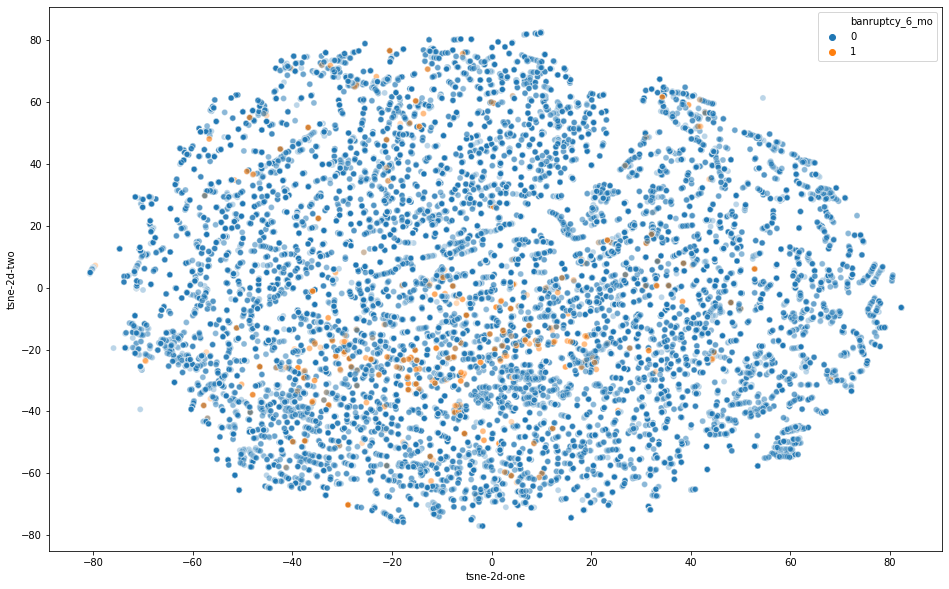

In [44]:
all_dat['tsne-2d-one'] = tsne_results[:,0]
all_dat['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="banruptcy_6_mo",
    data=all_dat,
    legend="full",
    alpha=0.3
)

In [50]:
import plotly.express as px
import datetime as dt
all_dat =all_dat.sort_values(by='Filing Date').reset_index(drop=True)
all_chrt = all_dat[all_dat.d_to_bankruptcy!=0]
#all_chrt = all_dat
px.scatter(all_chrt, x="tsne-2d-one", y="tsne-2d-two", 
           animation_frame=all_chrt['Filing Date'].dt.to_period('Q').astype(str), 
           animation_group="Name",
           hover_data=['d_to_bankruptcy'],
           color=all_chrt["predict"].astype(str), 
           hover_name="Name",
          range_x=[-85,85], range_y=[-85,85])

In [54]:
m1 = (all_dat['Name'] == 'Stone Energy Corporation')
all_dat.loc[m1][['CIK','Name','Filings','Filing Date','predict','banruptcy_6_mo','d_to_bankruptcy']]

,CIK,Name,Filings,Filing Date,predict,banruptcy_6_mo,d_to_bankruptcy
2290,904080,Stone Energy Corporation,10-K,2014-02-27,0,0,1021.0
3665,904080,Stone Energy Corporation,10-Q,2014-05-05,0,0,954.0
5302,904080,Stone Energy Corporation,10-Q,2014-08-06,1,0,861.0
7046,904080,Stone Energy Corporation,10-Q,2014-11-06,1,0,769.0
8349,904080,Stone Energy Corporation,10-K,2015-02-26,1,0,657.0
10069,904080,Stone Energy Corporation,10-Q,2015-05-07,1,0,587.0
12660,904080,Stone Energy Corporation,10-Q,2015-11-05,1,0,405.0
13981,904080,Stone Energy Corporation,10-K,2016-02-26,1,1,292.0
15295,904080,Stone Energy Corporation,10-Q,2016-05-05,1,1,223.0
16434,904080,Stone Energy Corporation,10-Q,2016-08-03,1,1,133.0


In [55]:
all_dat.drop(['tsne-2d-one','tsne-2d-two'], in_place=True)
all_dat.to_pickle('FINAL_ALL_DAT.pkl')

In [64]:
all_dat

,level_0,index,CIK,Ticker,Name,Filings,Description,Filing Date,File/Film Number,links,...,accounts payable and accrued liabilities_cumsum,accrued liabilities_cumsum,accounts receivable_cumsum,other current liabilities_cumsum,liquidity_ratio_cumsum,debt_to_equity_cumsum,debt_ratio_cumsum,predict,tsne-2d-one,tsne-2d-two
0,27236,27307,84129,RAD,Rite Aid Corp,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2013-10-03,001-05742131132591,/Archives/edgar/data/84129/000104746913009488/...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,35.124935,3.981538
1,10939,10965,33002,EBF,Ennis Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2013-10-04,001-05807131136369,/Archives/edgar/data/33002/000119312513391430/...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,-40.662472,-55.833817
2,33264,33360,97472,TXI,Texas Industries Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2013-10-04,001-04887131137205,/Archives/edgar/data/97472/000009747213000026/...,...,NaN,NaN,NaN,120254.366667,2.185393,-0.215296,0.613422,0,6.266305,-52.075748
3,27827,27898,1087423,RHT,Red Hat Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2013-10-04,001-33162131136873,/Archives/edgar/data/1087423/00011931251339160...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,36.559509,-28.666567
4,18633,18687,1170010,KMX,Carmax Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2013-10-07,001-31420131139199,/Archives/edgar/data/1170010/00011700101300002...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,52.517918,10.195582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34959,7186,7208,22444,CMC,Commercial Metals Co,10-K,"Annual report [Section 13 and 15(d), not S-K I...",2020-10-15,001-04304201241129,/Archives/edgar/data/22444/000002244420000047/...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,31.988443,-16.601933
34960,33350,33446,100517,UAL,United Continental Holdings Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2020-10-15,001-06033201241578,/Archives/edgar/data/100517/000010051720000056...,...,NaN,NaN,NaN,-296.000000,0.464336,-0.011633,0.050571,0,-46.801373,2.519337
34961,17089,17137,1494448,IFT,Imperial Holdings Inc,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2020-10-15,001-35064201241601,/Archives/edgar/data/1494448/00014944482000006...,...,-286.0,NaN,NaN,-40.000000,0.145714,-0.027699,NaN,0,-67.028152,-20.167160
34962,13020,13051,922358,FGP,Ferrellgas Partners LP,10-K,"Annual report [Section 13 and 15(d), not S-K I...",2020-10-15,001-11331201240318,/Archives/edgar/data/922358/000155837020011490...,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,30.888517,50.076729


In [97]:
import datetime
mask = all_dat['Filing Date']>= datetime.datetime.now() - datetime.timedelta(days=365)
year_dat = all_dat[mask]
watchlist = year_dat.groupby(['CIK']).sum()[['predict','d_to_bankruptcy']]
m_watch = (watchlist['predict']>0) &  (watchlist['d_to_bankruptcy']==0)
watchlist[m_watch]
year_dat[year_dat.CIK.isin(watchlist[m_watch].index.tolist())].groupby(['Name','Filing Date','Filings']).sum()

level_0  index      CIK  \
Name                      Filing Date Filings                            
Actuant Corp              2019-10-29  10-K        3049   3052     6955   
                          2020-01-06  10-Q        3048   3051     6955   
                          2020-03-25  10-Q        3047   3050     6955   
                          2020-07-01  10-Q        3046   3049     6955   
Albany International Corp 2019-10-30  10-Q        1203   1205   819793   
...                                                ...    ...      ...   
US Silica Holdings Inc    2019-10-30  10-Q       29660  29741  1524741   
                          2020-02-25  10-K       29659  29740  1524741   
                          2020-05-01  10-Q       29658  29739  1524741   
                          2020-07-31  10-Q       29657  29738  1524741   
Vitamin Shoppe Inc        2019-11-06  10-Q       34900  34997  1360530   

                                               current assets  \
Name                      Filing Date Filings                   
Actuant Corp              2019-10-29  10-K           380425.5   
                          2020-01-06  10-Q           247726.0   
                          2020-03-25  10-Q           220774.5   
                          2020-07-01  10-Q           211671.5   
Albany International Corp 2019-10-30  10-Q           599870.0   
...                                                       ...   
US Silica Holdings Inc    2019-10-30  10-Q           574123.0   
                          2020-02-25  10-K           509040.0   
                          2020-05-01  10-Q           514566.0   
                          2020-07-31  10-Q           457898.0   
Vitamin Shoppe Inc        2019-11-06  10-Q           221411.0   

                                               cash and cash equivalents  \
Name                      Filing Date Filings                              
Actuant Corp              2019-10-29  10-K                      211151.0   
                          2020-01-06  10-Q                      206780.0   
                          2020-03-25  10-Q                      163437.0   
                          2020-07-01  10-Q                      163603.0   
Albany International Corp 2019-10-30  10-Q                      173739.0   
...                                                                  ...   
US Silica Holdings Inc    2019-10-30  10-Q                      187289.0   
                          2020-02-25  10-K                      185740.0   
                          2020-05-01  10-Q                      144701.0   
                          2020-07-31  10-Q                      158676.0   
Vitamin Shoppe Inc        2019-11-06  10-Q                       15995.0   

                                               accounts receivable net  \
Name                      Filing Date Filings                            
Actuant Corp              2019-10-29  10-K                    125883.0   
                          2020-01-06  10-Q                    122027.0   
                          2020-03-25  10-Q                    113294.0   
                          2020-07-01  10-Q                     93796.0   
Albany International Corp 2019-10-30  10-Q                    224232.0   
...                                                                ...   
US Silica Holdings Inc    2019-10-30  10-Q                    204591.0   
                          2020-02-25  10-K                    182238.0   
                          2020-05-01  10-Q                    232855.0   
                          2020-07-31  10-Q                    158346.0   
Vitamin Shoppe Inc        2019-11-06  10-Q                         0.0   

                                               prepaid expenses  \
Name                      Filing Date Filings                     
Actuant Corp              2019-10-29  10-K                  0.0   
                          2020-01-06  10-Q                  0.0   
                  

In [104]:
mask = all_dat['Filing Date']>= datetime.datetime.now() - datetime.timedelta(days=365)
year_dat = all_dat[mask]
watchlist = year_dat.groupby(['CIK']).sum()[['predict','d_to_bankruptcy']]
m_watch = (watchlist['predict']>0) &  (watchlist['d_to_bankruptcy']==0)
year_dat=year_dat[year_dat.CIK.isin(watchlist[m_watch].index.tolist())].groupby(['Name','Filing Date','Filings'],as_index=False).sum()


In [105]:
year_dat1=year_dat[['CIK','Name','Filings','Filing Date','predict','banruptcy_6_mo','d_to_bankruptcy']+X_cols]

In [106]:
year_dat1

,CIK,Name,Filings,Filing Date,predict,banruptcy_6_mo,d_to_bankruptcy,current assets,cash and cash equivalents,accounts receivable net,...,deferred revenue,other,accrued interest,inventory,asset retirement obligations,retained deficit,accounts payable and accrued liabilities,accrued liabilities,accounts receivable,other current liabilities
0,6955,Actuant Corp,10-K,2019-10-29,1,0,0.0,380425.5,211151.0,125883.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125883.0,129779.333333
1,6955,Actuant Corp,10-Q,2020-01-06,0,0,0.0,247726.0,206780.0,122027.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122027.0,100766.333333
2,6955,Actuant Corp,10-Q,2020-03-25,0,0,0.0,220774.5,163437.0,113294.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113294.0,86924.333333
3,6955,Actuant Corp,10-Q,2020-07-01,0,0,0.0,211671.5,163603.0,93796.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93796.0,85388.666667
4,819793,Albany International Corp,10-Q,2019-10-30,1,0,0.0,599870.0,173739.0,224232.0,...,0.0,0.0,0.0,105705.0,0.0,0.0,0.0,122741.0,224232.0,154847.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1524741,US Silica Holdings Inc,10-Q,2019-10-30,0,0,0.0,574123.0,187289.0,204591.0,...,75170.0,0.0,0.0,0.0,0.0,0.0,245247.0,0.0,204591.0,339190.000000
340,1524741,US Silica Holdings Inc,10-K,2020-02-25,0,0,0.0,509040.0,185740.0,182238.0,...,35523.0,0.0,0.0,0.0,0.0,-279956.0,248237.0,0.0,182238.0,335398.000000
341,1524741,US Silica Holdings Inc,10-Q,2020-05-01,0,0,0.0,514566.0,144701.0,232855.0,...,38310.0,0.0,0.0,0.0,0.0,-353862.0,196959.0,0.0,232855.0,297393.000000
342,1524741,US Silica Holdings Inc,10-Q,2020-07-31,1,0,0.0,457898.0,158676.0,158346.0,...,32968.0,0.0,0.0,0.0,0.0,-386110.0,125921.0,0.0,158346.0,127126.500000
